# Five Tribes of Machine Learning: Iris Classification
## An Educational Demonstration

Welcome! This notebook demonstrates how the five tribes of machine learning (from Pedro Domingos' book "The Master Algorithm") each approach the classic Iris flower classification problem.

### The Five Tribes:
- 🌳 **Symbolists** - Learn through logical rules
- 🧠 **Connectionists** - Learn by mimicking the brain
- 🧬 **Evolutionaries** - Learn through simulated evolution
- 📊 **Bayesians** - Learn through probabilistic inference
- 📏 **Analogizers** - Learn by recognizing similarity

### What You'll Learn:
1. How different ML paradigms approach the same problem
2. The philosophical differences between approaches
3. When to use each type of algorithm
4. Working implementations you can modify and experiment with

## Table of Contents
1. [Introduction](#introduction)
2. [Problem Setup](#problem-setup)
3. [🌳 Symbolists: Decision Trees](#symbolists)
4. [🧠 Connectionists: Neural Networks](#connectionists)
5. [🧬 Evolutionaries: Genetic Programming](#evolutionaries)
6. [📊 Bayesians: Naive Bayes](#bayesians)
7. [📏 Analogizers: k-Nearest Neighbors](#analogizers)
8. [Comparison & Conclusion](#comparison)
9. [Glossary](#glossary)

In [1]:
# Install dependencies for Google Colab
# This cell will automatically detect if you're running in Colab and install required packages
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab - installing dependencies...")
    !pip install -q numpy pandas matplotlib seaborn scikit-learn keras jax deap
    print("✓ All dependencies installed successfully!")
except ImportError:
    IN_COLAB = False
    print("Not running in Colab - assuming dependencies are already installed.")

Not running in Colab - assuming dependencies are already installed.


## ⚠️ Important: Run Cells in Order

**This notebook must be run sequentially from top to bottom!**

Each section builds on variables created in previous sections:
1. First, we install dependencies (if in Colab)
2. Then we import libraries and set up the environment
3. Then we load and split the data
4. Finally, we can run the five tribe implementations

**If you get a `NameError` (like `X_train is not defined`):**
- Go to the menu: `Runtime → Run all` to execute all cells in order
- Or manually run each cell from top to bottom using Shift+Enter

Let's verify everything is set up correctly:

In [2]:
# Configure Keras to use JAX backend (must be set before importing keras)
import os
os.environ['KERAS_BACKEND'] = 'jax'

# Standard library imports
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning - General
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

# Machine learning - Tribe specific
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Neural networks - Keras 3.x with JAX backend
import keras
from keras import layers

# Genetic algorithms
from deap import base, creator, tools, algorithms
import random

# Set random seeds for reproducibility
np.random.seed(42)
keras.utils.set_random_seed(42)
random.seed(42)

# Plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("All imports successful! ✓")
print(f"Using Keras backend: {keras.backend.backend()}")

All imports successful! ✓
Using Keras backend: jax


<a id="introduction"></a>
## Introduction

Machine learning isn't just one thing—it's a collection of fundamentally different approaches to learning from data. Pedro Domingos, in his book "The Master Algorithm," identifies five major "tribes" of machine learning, each with its own philosophy and techniques.

**Why does this matter?** Because understanding these different paradigms helps you:
- Choose the right algorithm for your problem
- Understand why an algorithm works (or doesn't)
- Combine approaches for better results
- Think more deeply about what "learning" really means

In this notebook, we'll see how each tribe tackles the same problem: classifying iris flowers based on their physical measurements. By the end, you'll understand not just *that* different algorithms exist, but *why* they approach problems differently.

<a id="problem-setup"></a>
## Problem Setup: The Iris Dataset

The Iris dataset is the "Hello World" of machine learning. It contains measurements of 150 iris flowers from three species:
- **Setosa**
- **Versicolor**
- **Virginica**

For each flower, we have four measurements:
1. Sepal length (cm)
2. Sepal width (cm)
3. Petal length (cm)
4. Petal width (cm)

**Our task:** Given these four measurements, predict which species the flower belongs to.

**Why Iris?** It's simple enough to understand but complex enough to be non-trivial. Perfect for comparing different approaches!

In [3]:
# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

# Create a DataFrame for easier exploration
df = pd.DataFrame(X, columns=feature_names)
df['species'] = pd.Categorical.from_codes(y, target_names)

print(f"Dataset shape: {X.shape}")
print(f"Number of samples: {len(X)}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of classes: {len(target_names)}")
print(f"\nClass distribution:")
print(df['species'].value_counts())
print(f"\nFirst 5 samples:")
df.head()

Dataset shape: (150, 4)
Number of samples: 150
Number of features: 4
Number of classes: 3

Class distribution:
species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

First 5 samples:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


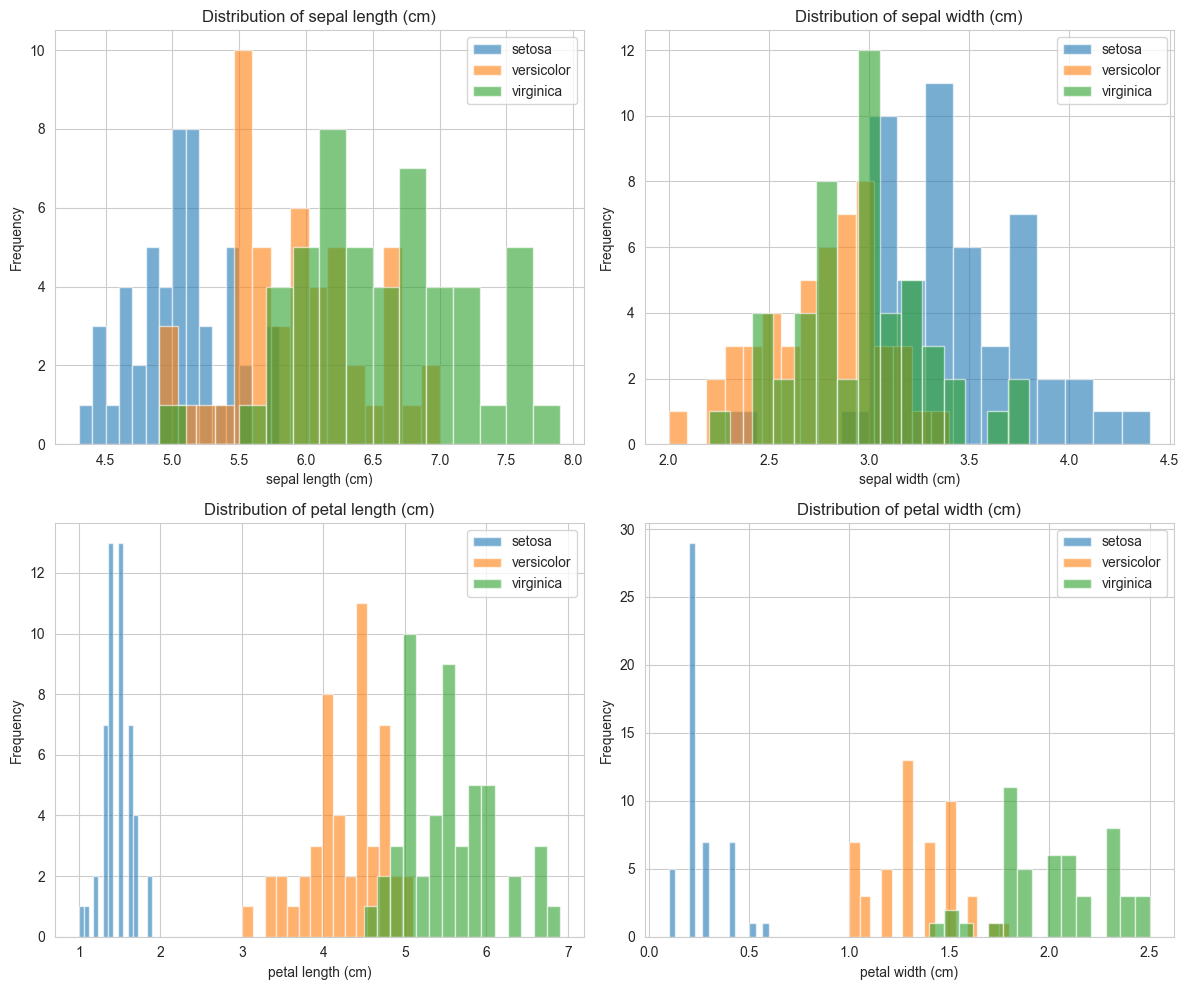

💡 Notice how some features (like petal length) separate the species better than others!


In [4]:
# Visualize the data
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for idx, feature in enumerate(feature_names):
    row = idx // 2
    col = idx % 2
    for species_idx, species in enumerate(target_names):
        species_data = df[df['species'] == species][feature]
        axes[row, col].hist(species_data, alpha=0.6, label=species, bins=15)
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].legend()
    axes[row, col].set_title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

print("💡 Notice how some features (like petal length) separate the species better than others!")

In [5]:
# Split into training and testing sets
# We'll use the same split for all five tribes to ensure fair comparison
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples")
print(f"\nTraining set class distribution:")
print(pd.Series(y_train).value_counts().sort_index())
print(f"\nTest set class distribution:")
print(pd.Series(y_test).value_counts().sort_index())

Training set size: 120 samples
Test set size: 30 samples

Training set class distribution:
0    40
1    40
2    40
Name: count, dtype: int64

Test set class distribution:
0    10
1    10
2    10
Name: count, dtype: int64


<a id="symbolists"></a>
## 🌳 Symbolists: Decision Trees

### Philosophy

Symbolists believe that learning is the **inverse of deduction**. Just as you can deduce specific conclusions from general rules, Symbolists learn by inducing general rules from specific examples.

**Real-world analogy:** Think of how a detective works. They see clues (data) and build up a theory (rules) that explains all the evidence. "If the footprint is larger than 12 inches AND the suspect is over 6 feet tall, THEN consider this person of interest."

**Master Algorithm:** Inverse deduction

### Key Concepts

- **Logic and Rules**: Learning produces human-readable "if-then" rules
- **Interpretability**: You can understand exactly why the algorithm made a decision
- **Tree Structure**: Rules are organized hierarchically like a flowchart
- **Greedy Splitting**: At each step, choose the split that best separates the classes
- **Decision Boundaries**: Creates rectangular decision regions in feature space

In [6]:
# Create and train a decision tree
tree_model = DecisionTreeClassifier(
    max_depth=3,  # Limit depth for interpretability
    random_state=42
)

tree_model.fit(X_train, y_train)

# Make predictions
y_pred_tree = tree_model.predict(X_test)

# Evaluate
accuracy_tree = accuracy_score(y_test, y_pred_tree)
print(f"Decision Tree Accuracy: {accuracy_tree:.3f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_tree, target_names=target_names))

Decision Tree Accuracy: 0.967

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



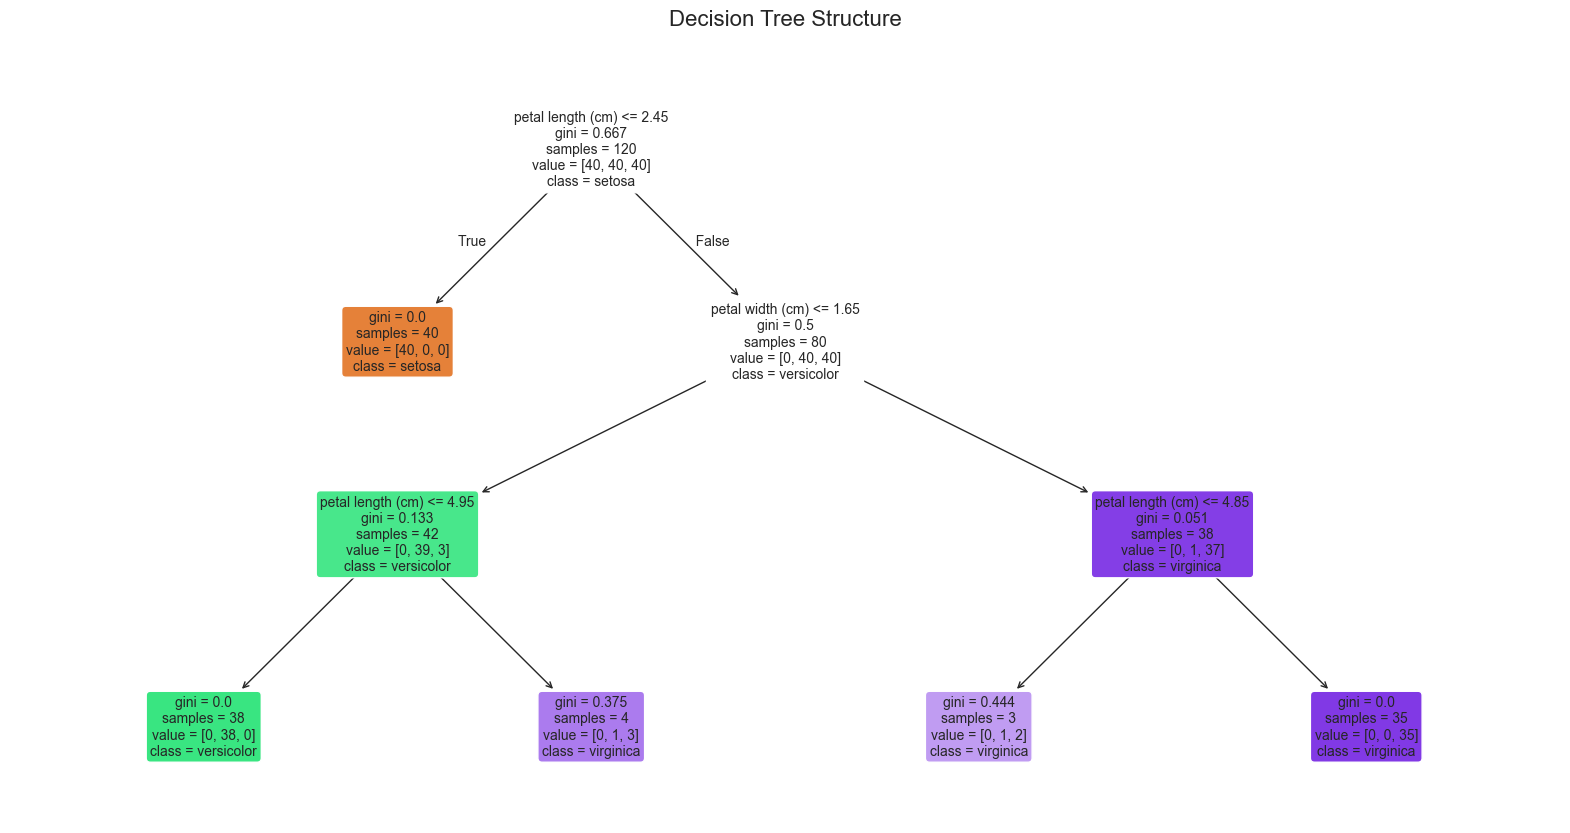


📋 Decision Rules (text format):
|--- petal length (cm) <= 2.45
|   |--- class: 0
|--- petal length (cm) >  2.45
|   |--- petal width (cm) <= 1.65
|   |   |--- petal length (cm) <= 4.95
|   |   |   |--- class: 1
|   |   |--- petal length (cm) >  4.95
|   |   |   |--- class: 2
|   |--- petal width (cm) >  1.65
|   |   |--- petal length (cm) <= 4.85
|   |   |   |--- class: 2
|   |   |--- petal length (cm) >  4.85
|   |   |   |--- class: 2



In [7]:
# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    tree_model,
    feature_names=feature_names,
    class_names=target_names,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Structure", fontsize=16, pad=20)
plt.show()

# Show the rules in text format
print("\n📋 Decision Rules (text format):")
print("="*50)
tree_rules = export_text(tree_model, feature_names=feature_names)
print(tree_rules)

### Results & Interpretation

The decision tree creates a flowchart of questions about the flowers' measurements. Notice how it:

1. **Starts with the most informative feature** (usually petal-related measurements)
2. **Creates simple yes/no questions** at each node
3. **Produces human-readable rules** you could write down on paper

**Strengths of the Symbolist approach:**
- ✅ Highly interpretable—you can explain every decision
- ✅ No data preprocessing needed (no scaling required)
- ✅ Handles both numerical and categorical data
- ✅ Automatically does feature selection

**Weaknesses:**
- ❌ Can overfit if not constrained (tree too deep)
- ❌ Unstable—small data changes can produce different trees
- ❌ Creates axis-aligned boundaries (can't capture diagonal patterns well)

**When to use:** When you need to explain your model's decisions to stakeholders, or when interpretability is crucial (medical diagnosis, loan approval, etc.)

<a id="connectionists"></a>
## 🧠 Connectionists: Neural Networks

### Philosophy

Connectionists believe that intelligence emerges from **networks of simple units** working together, just like neurons in the brain. Learning happens by adjusting the connections between these units.

**Real-world analogy:** Think of learning to ride a bike. You don't learn explicit rules—instead, your brain's neural connections gradually adjust through practice until the right patterns emerge. You can't explain *how* you balance, but your brain knows.

**Master Algorithm:** Backpropagation

### Key Concepts

- **Neurons and Layers**: Simple processing units organized in layers
- **Weights and Biases**: Connections between neurons have adjustable strengths
- **Activation Functions**: Non-linear transformations that enable complex patterns
- **Gradient Descent**: Learning by following the slope of the error downhill
- **Backpropagation**: Efficiently computing how to adjust weights to reduce error

In [8]:
# Neural networks work better with scaled data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data scaled for neural network training ✓")
print(f"Original range: [{X_train.min():.2f}, {X_train.max():.2f}]")
print(f"Scaled range: [{X_train_scaled.min():.2f}, {X_train_scaled.max():.2f}]")

Data scaled for neural network training ✓
Original range: [0.10, 7.90]
Scaled range: [-2.35, 3.03]


In [9]:
# Build a simple neural network
nn_model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=(4,), name='hidden_layer_1'),
    layers.Dense(8, activation='relu', name='hidden_layer_2'),
    layers.Dense(3, activation='softmax', name='output_layer')
])

# Compile the model
nn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display architecture
print("Neural Network Architecture:")
print("="*50)
nn_model.summary()

Neural Network Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243 (972.00 B)

 Trainable params: 243 (972.00 B)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train the neural network
history = nn_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    verbose=0
)

# Make predictions
y_pred_probs = nn_model.predict(X_test_scaled, verbose=0)
y_pred_nn = np.argmax(y_pred_probs, axis=1)

# Evaluate
accuracy_nn = accuracy_score(y_test, y_pred_nn)
print(f"Neural Network Accuracy: {accuracy_nn:.3f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_nn, target_names=target_names))

Neural Network Accuracy: 0.900

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.89      0.80      0.84        10
   virginica       0.82      0.90      0.86        10

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30



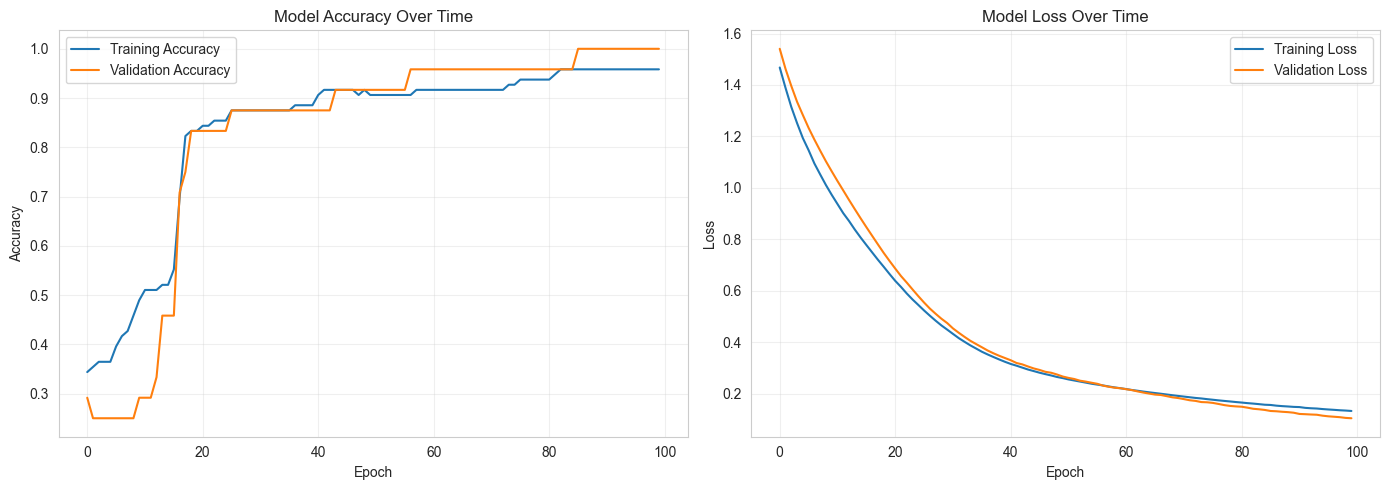

💡 Notice how the model learns: loss decreases and accuracy increases over epochs!


In [11]:
# Visualize training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy Over Time')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss Over Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 Notice how the model learns: loss decreases and accuracy increases over epochs!")

### Results & Interpretation

The neural network learned by repeatedly adjusting its weights through backpropagation. Notice how:

1. **Learning is gradual** - accuracy improves smoothly over epochs
2. **It's a black box** - we can't easily explain individual decisions
3. **It learns non-linear patterns** - the hidden layers capture complex relationships

**Strengths of the Connectionist approach:**
- ✅ Can learn very complex, non-linear patterns
- ✅ Scales well to large datasets
- ✅ Can be extended (add more layers) for harder problems
- ✅ Works well with raw data (images, audio, text)

**Weaknesses:**
- ❌ Black box—hard to interpret why it made a decision
- ❌ Requires lots of data to avoid overfitting
- ❌ Needs careful tuning (learning rate, architecture, etc.)
- ❌ Computationally expensive to train

**When to use:** When you have lots of data, complex patterns to learn, and don't need to explain individual predictions (image recognition, speech recognition, etc.)

<a id="evolutionaries"></a>
## 🧬 Evolutionaries: Genetic Algorithms

### Philosophy

Evolutionaries believe that learning is **simulated evolution**. Just as species evolve through natural selection, algorithms can evolve through mutation, crossover, and survival of the fittest.

**Real-world analogy:** Think of breeding dogs. You start with a diverse population, select the best ones (fastest, strongest, friendliest), breed them to create offspring with mixed traits, and occasionally get random mutations. Over generations, the population gets better at whatever you're selecting for.

**Master Algorithm:** Genetic programming

### Key Concepts

- **Population**: Multiple candidate solutions compete
- **Fitness**: How well each candidate performs
- **Selection**: Better candidates more likely to reproduce
- **Crossover**: Combine two parents to create offspring
- **Mutation**: Random changes to maintain diversity
- **Evolution**: Populations improve over generations

**Note:** For simplicity, we'll use genetic algorithms to optimize the parameters of a k-NN classifier rather than full genetic programming.

In [12]:
# Set up DEAP for genetic algorithm
# We'll evolve a simple classifier by optimizing feature weights

# Create fitness and individual classes
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Each gene is a feature weight between 0 and 1
toolbox.register("attr_float", random.uniform, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=4)  # 4 features
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def eval_individual(individual, X_train, y_train, X_val, y_val):
    """Evaluate fitness by weighting features and testing accuracy"""
    weights = np.array(individual)
    
    # Apply feature weights
    X_train_weighted = X_train * weights
    X_val_weighted = X_val * weights
    
    # Train simple k-NN classifier
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train_weighted, y_train)
    
    # Return accuracy as fitness
    accuracy = knn.score(X_val_weighted, y_val)
    return (accuracy,)

# Create validation split
X_train_evo, X_val_evo, y_train_evo, y_val_evo = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Register genetic operators
toolbox.register("evaluate", eval_individual,
                 X_train=X_train_evo, y_train=y_train_evo,
                 X_val=X_val_evo, y_val=y_val_evo)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

print("Genetic algorithm components initialized ✓")

Genetic algorithm components initialized ✓


In [13]:
# Run the genetic algorithm
population_size = 50
num_generations = 40

# Create initial population
pop = toolbox.population(n=population_size)

# Track statistics
fitness_over_time = []
best_fitness_over_time = []

print("Starting evolution...")
print("="*50)

for gen in range(num_generations):
    # Evaluate all individuals
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    
    # Track progress
    fits = [ind.fitness.values[0] for ind in pop]
    fitness_over_time.append(np.mean(fits))
    best_fitness_over_time.append(np.max(fits))
    
    if gen % 10 == 0:
        print(f"Generation {gen}: Avg Fitness = {np.mean(fits):.3f}, "
              f"Best Fitness = {np.max(fits):.3f}")
    
    # Select and breed next generation
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))
    
    # Apply crossover
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < 0.7:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values
    
    # Apply mutation
    for mutant in offspring:
        if random.random() < 0.2:
            toolbox.mutate(mutant)
            del mutant.fitness.values
    
    pop[:] = offspring

# Get best individual
best_ind = tools.selBest(pop, 1)[0]
best_weights = np.array(best_ind)

print("\n" + "="*50)
print(f"Evolution complete!")
print(f"Best feature weights: {best_weights}")

Starting evolution...
Generation 0: Avg Fitness = 0.927, Best Fitness = 0.958


Generation 10: Avg Fitness = 0.948, Best Fitness = 0.958


Generation 20: Avg Fitness = 0.957, Best Fitness = 0.958


Generation 30: Avg Fitness = 0.958, Best Fitness = 0.958



Evolution complete!
Best feature weights: [0.36794219 0.18321046 0.82180496 0.32340829]


In [14]:
# Test the evolved solution
X_test_weighted = X_test * best_weights

# Train final model with evolved weights
knn_evo = KNeighborsClassifier(n_neighbors=3)
knn_evo.fit(X_train * best_weights, y_train)

# Predict
y_pred_evo = knn_evo.predict(X_test_weighted)

# Evaluate
accuracy_evo = accuracy_score(y_test, y_pred_evo)
print(f"Genetic Algorithm Accuracy: {accuracy_evo:.3f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_evo, target_names=target_names))

print(f"\n💡 Feature importance (evolved weights):")
for feature, weight in zip(feature_names, best_weights):
    print(f"  {feature}: {weight:.3f}")

Genetic Algorithm Accuracy: 0.967

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30


💡 Feature importance (evolved weights):
  sepal length (cm): 0.368
  sepal width (cm): 0.183
  petal length (cm): 0.822
  petal width (cm): 0.323


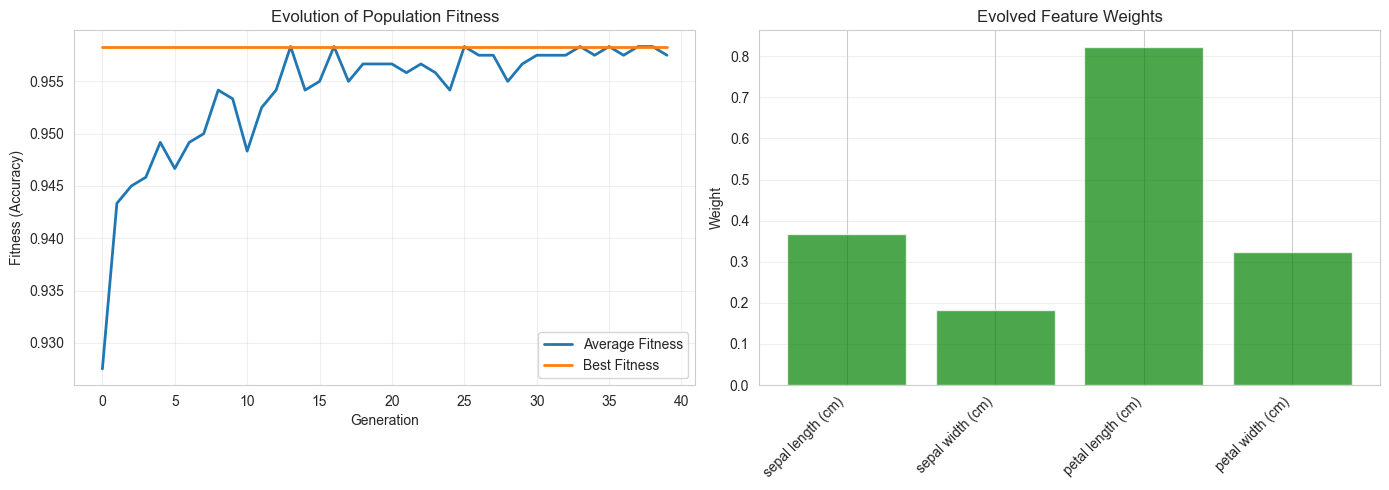

💡 Notice how the population improves over generations through selection and variation!


In [15]:
# Visualize evolution progress
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot fitness over generations
axes[0].plot(fitness_over_time, label='Average Fitness', linewidth=2)
axes[0].plot(best_fitness_over_time, label='Best Fitness', linewidth=2)
axes[0].set_xlabel('Generation')
axes[0].set_ylabel('Fitness (Accuracy)')
axes[0].set_title('Evolution of Population Fitness')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot feature weights
axes[1].bar(range(len(feature_names)), best_weights, color='green', alpha=0.7)
axes[1].set_xticks(range(len(feature_names)))
axes[1].set_xticklabels(feature_names, rotation=45, ha='right')
axes[1].set_ylabel('Weight')
axes[1].set_title('Evolved Feature Weights')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("💡 Notice how the population improves over generations through selection and variation!")

### Results & Interpretation

The genetic algorithm evolved feature weights through natural selection. Notice how:

1. **Fitness improves over generations** - the population adapts to the problem
2. **Diversity matters** - mutation prevents premature convergence
3. **No gradients needed** - works even when we can't compute derivatives

**Strengths of the Evolutionary approach:**
- ✅ Works on any fitness function (no need for gradients)
- ✅ Can optimize discrete or continuous parameters
- ✅ Good at avoiding local optima (thanks to diversity)
- ✅ Naturally parallelizable (evaluate population in parallel)

**Weaknesses:**
- ❌ Computationally expensive (many fitness evaluations)
- ❌ Slow convergence compared to gradient-based methods
- ❌ Many hyperparameters to tune (population size, mutation rate, etc.)
- ❌ No guarantees of finding global optimum

**When to use:** When you can't compute gradients, have a complex search space, or need to optimize discrete structures (network architectures, rule sets, etc.)

<a id="bayesians"></a>
## 📊 Bayesians: Naive Bayes Classifier

### Philosophy

Bayesians believe that learning is a form of **probabilistic inference**. All learning is about updating your beliefs based on evidence using Bayes' theorem.

**Real-world analogy:** Think of a doctor diagnosing a patient. They start with prior knowledge (how common is this disease?), observe symptoms (evidence), and update their belief about what the patient has. More evidence = more confident diagnosis.

**Master Algorithm:** Bayesian inference

### Key Concepts

- **Prior Probability**: What we believe before seeing evidence
- **Likelihood**: How probable is this evidence given the hypothesis?
- **Posterior Probability**: Updated belief after seeing evidence
- **Bayes' Theorem**: P(Hypothesis|Evidence) = P(Evidence|Hypothesis) × P(Hypothesis) / P(Evidence)
- **Naive Assumption**: Features are independent (simplifies calculation)

**Formula:**
```
P(Species|Measurements) ∝ P(Measurements|Species) × P(Species)
```

In [16]:
# Create and train Naive Bayes classifier
nb_model = GaussianNB()

nb_model.fit(X_train, y_train)

# Make predictions
y_pred_nb = nb_model.predict(X_test)
y_pred_proba_nb = nb_model.predict_proba(X_test)

# Evaluate
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Accuracy: {accuracy_nb:.3f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_nb, target_names=target_names))

# Show example predictions with probabilities
print("\n📊 Example predictions with probabilities:")
print("="*60)
for i in range(5):
    true_class = target_names[y_test[i]]
    pred_class = target_names[y_pred_nb[i]]
    probs = y_pred_proba_nb[i]
    print(f"Sample {i+1}: True={true_class}, Predicted={pred_class}")
    for j, species in enumerate(target_names):
        print(f"  P({species}|measurements) = {probs[j]:.3f}")
    print()

Naive Bayes Accuracy: 0.967

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30


📊 Example predictions with probabilities:
Sample 1: True=setosa, Predicted=setosa
  P(setosa|measurements) = 1.000
  P(versicolor|measurements) = 0.000
  P(virginica|measurements) = 0.000

Sample 2: True=virginica, Predicted=virginica
  P(setosa|measurements) = 0.000
  P(versicolor|measurements) = 0.088
  P(virginica|measurements) = 0.912

Sample 3: True=versicolor, Predicted=versicolor
  P(setosa|measurements) = 0.000
  P(versicolor|measurements) = 1.000
  P(virginica|measurements) = 0.000

Sample 4: True=versicolor, Predicted=versicolor
  P(setosa|measuremen

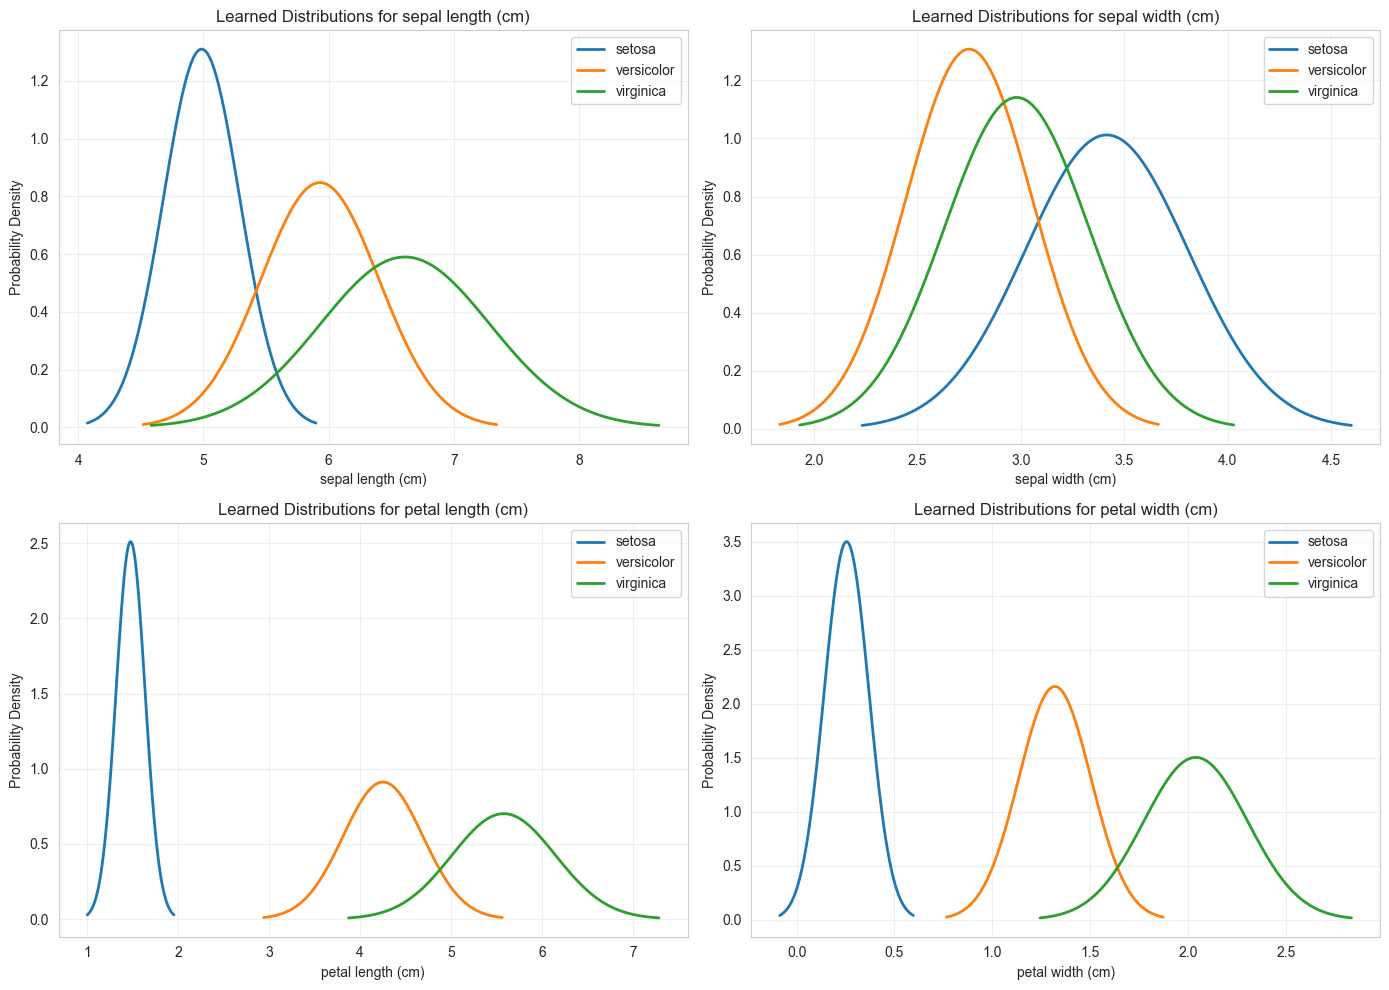

💡 The classifier learned the probability distribution of each feature for each species!


In [17]:
# Visualize probability distributions for each class
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, feature in enumerate(feature_names):
    row = idx // 2
    col = idx % 2
    
    # For each class, plot the learned Gaussian distribution
    for class_idx in range(3):
        # Get mean and variance for this feature and class
        mean = nb_model.theta_[class_idx, idx]
        var = nb_model.var_[class_idx, idx]
        std = np.sqrt(var)
        
        # Generate distribution curve
        x_range = np.linspace(mean - 3*std, mean + 3*std, 100)
        gaussian = (1 / (std * np.sqrt(2 * np.pi))) * \
                   np.exp(-0.5 * ((x_range - mean) / std) ** 2)
        
        axes[row, col].plot(x_range, gaussian, label=target_names[class_idx],
                           linewidth=2)
    
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Probability Density')
    axes[row, col].set_title(f'Learned Distributions for {feature}')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 The classifier learned the probability distribution of each feature for each species!")

📊 Prior Probabilities (from training data):
setosa       : 0.333 (40 samples)
versicolor   : 0.333 (40 samples)
virginica    : 0.333 (40 samples)


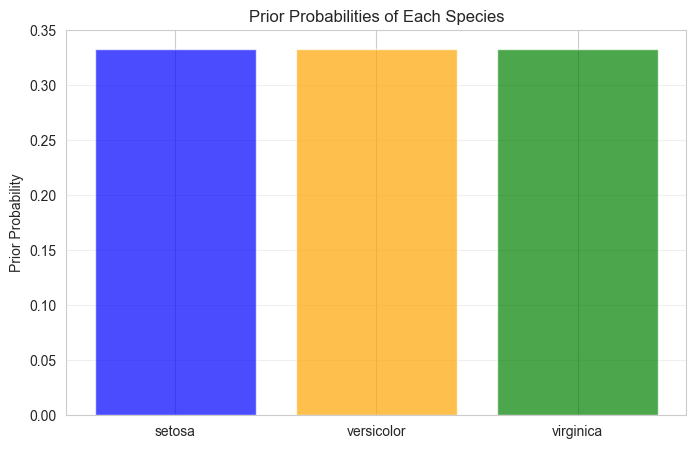

In [18]:
# Show prior and class probabilities
print("📊 Prior Probabilities (from training data):")
print("="*50)
for idx, species in enumerate(target_names):
    prior = nb_model.class_prior_[idx]
    count = nb_model.class_count_[idx]
    print(f"{species:12} : {prior:.3f} ({int(count)} samples)")

# Visualize
plt.figure(figsize=(8, 5))
plt.bar(target_names, nb_model.class_prior_, color=['blue', 'orange', 'green'], alpha=0.7)
plt.ylabel('Prior Probability')
plt.title('Prior Probabilities of Each Species')
plt.grid(True, alpha=0.3, axis='y')
plt.show()

### Results & Interpretation

The Naive Bayes classifier learned probability distributions for each feature. When classifying a new flower, it:

1. **Starts with priors** - how common is each species in the training data?
2. **Observes evidence** - what are this flower's measurements?
3. **Computes likelihoods** - how probable are these measurements for each species?
4. **Updates beliefs** - use Bayes' theorem to get posterior probabilities
5. **Makes decision** - pick the species with highest probability

**Strengths of the Bayesian approach:**
- ✅ Provides probability estimates, not just predictions
- ✅ Works well with small datasets
- ✅ Fast training and prediction
- ✅ Handles missing data gracefully
- ✅ Theoretically principled (based on probability theory)

**Weaknesses:**
- ❌ "Naive" independence assumption often violated
- ❌ Probability estimates can be overconfident
- ❌ Sensitive to how you model the distributions
- ❌ Can struggle with correlated features

**When to use:** When you need probability estimates (not just classifications), have limited data, or want a fast baseline. Great for text classification, spam filtering, and medical diagnosis.

<a id="analogizers"></a>
## 📏 Analogizers: k-Nearest Neighbors

### Philosophy

Analogizers believe that the key to learning is **recognizing similarity**. To classify something new, find similar examples you've seen before and predict based on them.

**Real-world analogy:** Think of how you identify mushrooms in the forest. You don't have explicit rules or probability distributions—you compare the mushroom you found to ones you've seen before. "This one looks like the edible mushrooms I know, so it's probably safe."

**Master Algorithm:** Support Vector Machine (but we'll use k-NN for simplicity)

### Key Concepts

- **Similarity/Distance**: Measure how "close" examples are to each other
- **No Training Phase**: Just memorize all the examples
- **Lazy Learning**: All the work happens at prediction time
- **k Neighbors**: Look at the k most similar examples
- **Majority Vote**: Predict the most common class among neighbors
- **Distance Metric**: Usually Euclidean distance in feature space

In [19]:
# Create and train k-NN classifier
# Try different values of k
k_values = [1, 3, 5, 7]
knn_models = {}
knn_accuracies = {}

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    knn_models[k] = knn
    knn_accuracies[k] = accuracy
    
    print(f"k={k}: Accuracy = {accuracy:.3f}")

# Use k=3 as our primary model
best_k = max(knn_accuracies, key=knn_accuracies.get)
knn_model = knn_models[best_k]
y_pred_knn = knn_model.predict(X_test)

print(f"\n{'='*50}")
print(f"Best k: {best_k}")
print(f"k-NN Accuracy: {knn_accuracies[best_k]:.3f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_knn, target_names=target_names))

k=1: Accuracy = 0.967


k=3: Accuracy = 1.000
k=5: Accuracy = 1.000
k=7: Accuracy = 0.967

Best k: 3
k-NN Accuracy: 1.000

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00        10
   virginica       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



Example: Classifying test sample 0
True class: setosa
Predicted class: setosa

📏 Nearest 3 neighbors:
Neighbor 1: Distance=0.141, Class=setosa
Neighbor 2: Distance=0.245, Class=setosa
Neighbor 3: Distance=0.300, Class=setosa


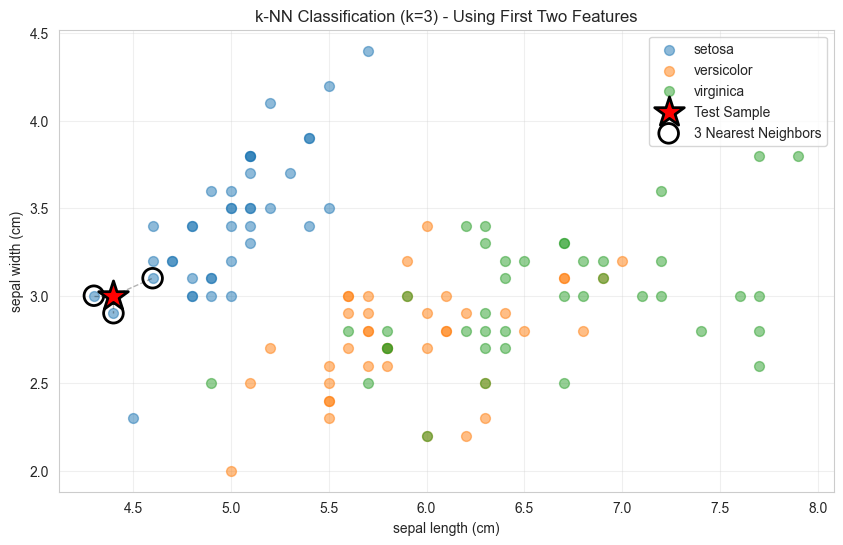


💡 The test sample is classified based on its nearest neighbors!


In [20]:
# Visualize how k-NN works for a test sample
test_idx = 0
test_sample = X_test[test_idx].reshape(1, -1)
true_label = y_test[test_idx]

# Find nearest neighbors
distances, indices = knn_model.kneighbors(test_sample, n_neighbors=5)

print(f"Example: Classifying test sample {test_idx}")
print(f"True class: {target_names[true_label]}")
print(f"Predicted class: {target_names[y_pred_knn[test_idx]]}")
print(f"\n📏 Nearest {best_k} neighbors:")
print("="*60)

for i, (dist, idx) in enumerate(zip(distances[0][:best_k], indices[0][:best_k])):
    neighbor_class = y_train[idx]
    print(f"Neighbor {i+1}: Distance={dist:.3f}, Class={target_names[neighbor_class]}")

# Visualize in 2D (using first two features)
plt.figure(figsize=(10, 6))

# Plot training data
for class_idx, species in enumerate(target_names):
    mask = y_train == class_idx
    plt.scatter(X_train[mask, 0], X_train[mask, 1],
               label=species, alpha=0.5, s=50)

# Plot test sample
plt.scatter(test_sample[0, 0], test_sample[0, 1],
           color='red', marker='*', s=500,
           edgecolors='black', linewidth=2,
           label='Test Sample', zorder=5)

# Plot nearest neighbors
neighbor_points = X_train[indices[0][:best_k]]
plt.scatter(neighbor_points[:, 0], neighbor_points[:, 1],
           color='black', marker='o', s=200,
           facecolors='none', linewidth=2,
           label=f'{best_k} Nearest Neighbors', zorder=4)

# Draw lines to neighbors
for neighbor in neighbor_points:
    plt.plot([test_sample[0, 0], neighbor[0]],
            [test_sample[0, 1], neighbor[1]],
            'k--', alpha=0.3, linewidth=1)

plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.title(f'k-NN Classification (k={best_k}) - Using First Two Features')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n💡 The test sample is classified based on its nearest neighbors!")

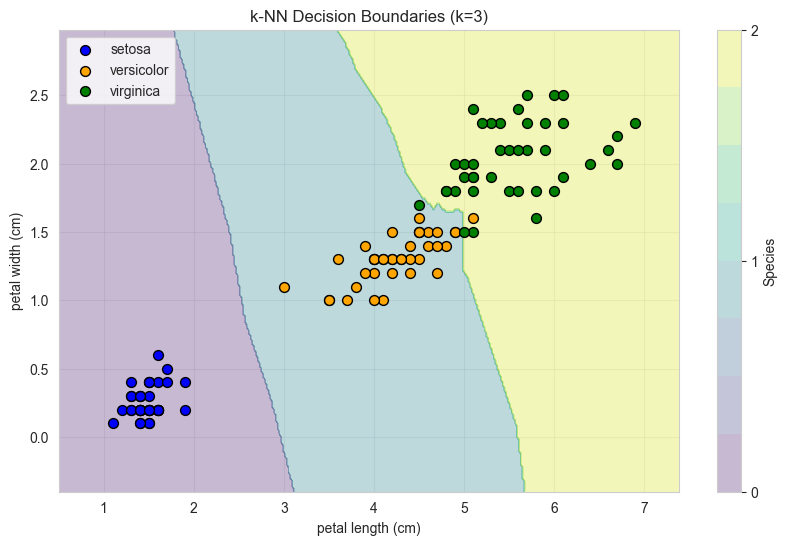

💡 Notice the smooth, organic boundaries - each region contains points similar to that class!


In [21]:
# Visualize decision boundaries (using petal length and width)
# These features separate the classes best
feature_idx = [2, 3]  # Petal length and width

# Create mesh
h = 0.02  # step size in mesh
x_min = X[:, feature_idx[0]].min() - 0.5
x_max = X[:, feature_idx[0]].max() + 0.5
y_min = X[:, feature_idx[1]].min() - 0.5
y_max = X[:, feature_idx[1]].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Train k-NN on just these two features
knn_2d = KNeighborsClassifier(n_neighbors=best_k)
knn_2d.fit(X_train[:, feature_idx], y_train)

# Predict over mesh
Z = knn_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
plt.colorbar(ticks=[0, 1, 2], label='Species')

# Plot training points
colors = ['blue', 'orange', 'green']
for class_idx, species in enumerate(target_names):
    mask = y_train == class_idx
    plt.scatter(X_train[mask, feature_idx[0]],
               X_train[mask, feature_idx[1]],
               c=colors[class_idx], label=species,
               edgecolors='black', s=50)

plt.xlabel(feature_names[feature_idx[0]])
plt.ylabel(feature_names[feature_idx[1]])
plt.title(f'k-NN Decision Boundaries (k={best_k})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("💡 Notice the smooth, organic boundaries - each region contains points similar to that class!")

### Results & Interpretation

k-NN is beautifully simple: to classify something, find similar examples and copy their labels. Notice how:

1. **No "training"** - just memorize the data
2. **Prediction is local** - only nearby points matter
3. **Decision boundaries are smooth** - follow the natural clustering of data
4. **k matters** - small k is sensitive to noise, large k is smooth but less precise

**Strengths of the Analogizer approach:**
- ✅ Extremely simple to understand and implement
- ✅ No assumptions about data distribution
- ✅ Naturally handles multi-class problems
- ✅ Can adapt to any decision boundary shape
- ✅ Easy to update (just add new examples)

**Weaknesses:**
- ❌ Slow prediction (must search all training data)
- ❌ Memory intensive (stores all training data)
- ❌ Sensitive to irrelevant features and scale
- ❌ Struggles in high dimensions ("curse of dimensionality")

**When to use:** When you have moderate-sized datasets, need to explain predictions by example, or want a simple baseline. Great for recommendation systems, image classification, and pattern recognition.

<a id="comparison"></a>
## Comparison & Conclusion

Now that we've seen all five tribes in action, let's compare their performance and understand when to use each approach.

📊 Performance Comparison
                       Tribe  Accuracy
          Analogizers (k-NN)  1.000000
  Symbolists (Decision Tree)  0.966667
Evolutionaries (Genetic Alg)  0.966667
     Bayesians (Naive Bayes)  0.966667
 Connectionists (Neural Net)  0.900000


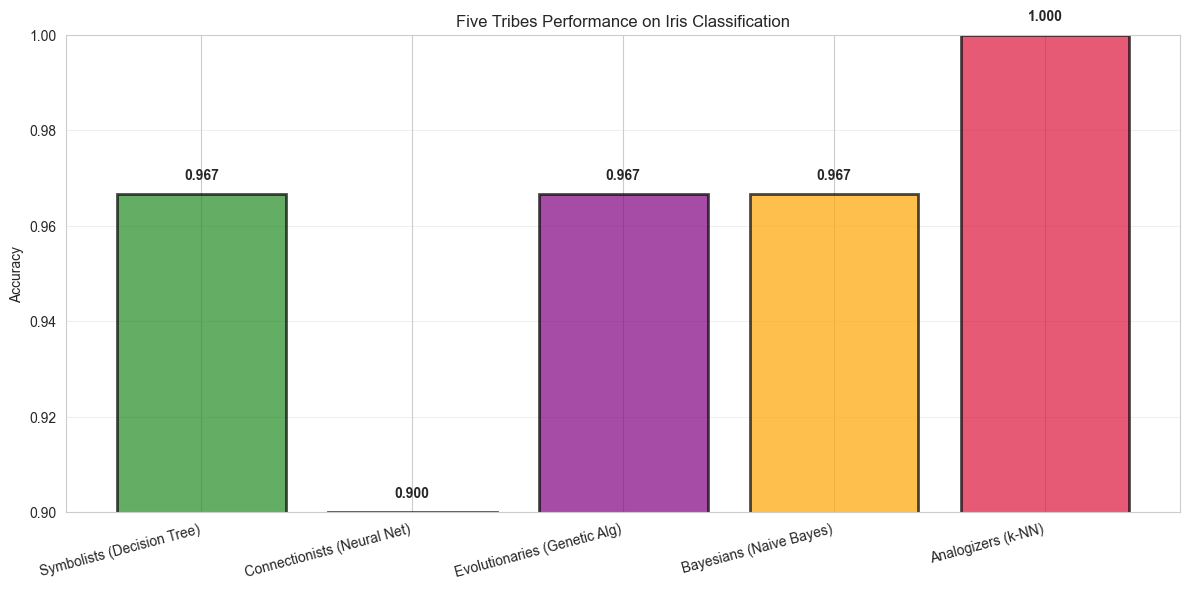

In [22]:
# Collect all results
results = {
    'Symbolists (Decision Tree)': accuracy_tree,
    'Connectionists (Neural Net)': accuracy_nn,
    'Evolutionaries (Genetic Alg)': accuracy_evo,
    'Bayesians (Naive Bayes)': accuracy_nb,
    'Analogizers (k-NN)': knn_accuracies[best_k]
}

# Create comparison DataFrame
results_df = pd.DataFrame({
    'Tribe': list(results.keys()),
    'Accuracy': list(results.values())
}).sort_values('Accuracy', ascending=False)

print("📊 Performance Comparison")
print("="*60)
print(results_df.to_string(index=False))

# Visualize
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(results)), results.values(),
               color=['forestgreen', 'navy', 'purple', 'orange', 'crimson'],
               alpha=0.7, edgecolor='black', linewidth=2)
plt.xticks(range(len(results)), results.keys(), rotation=15, ha='right')
plt.ylabel('Accuracy')
plt.title('Five Tribes Performance on Iris Classification')
plt.ylim([0.9, 1.0])  # Focus on differences
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (tribe, acc) in enumerate(results.items()):
    plt.text(i, acc + 0.003, f'{acc:.3f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

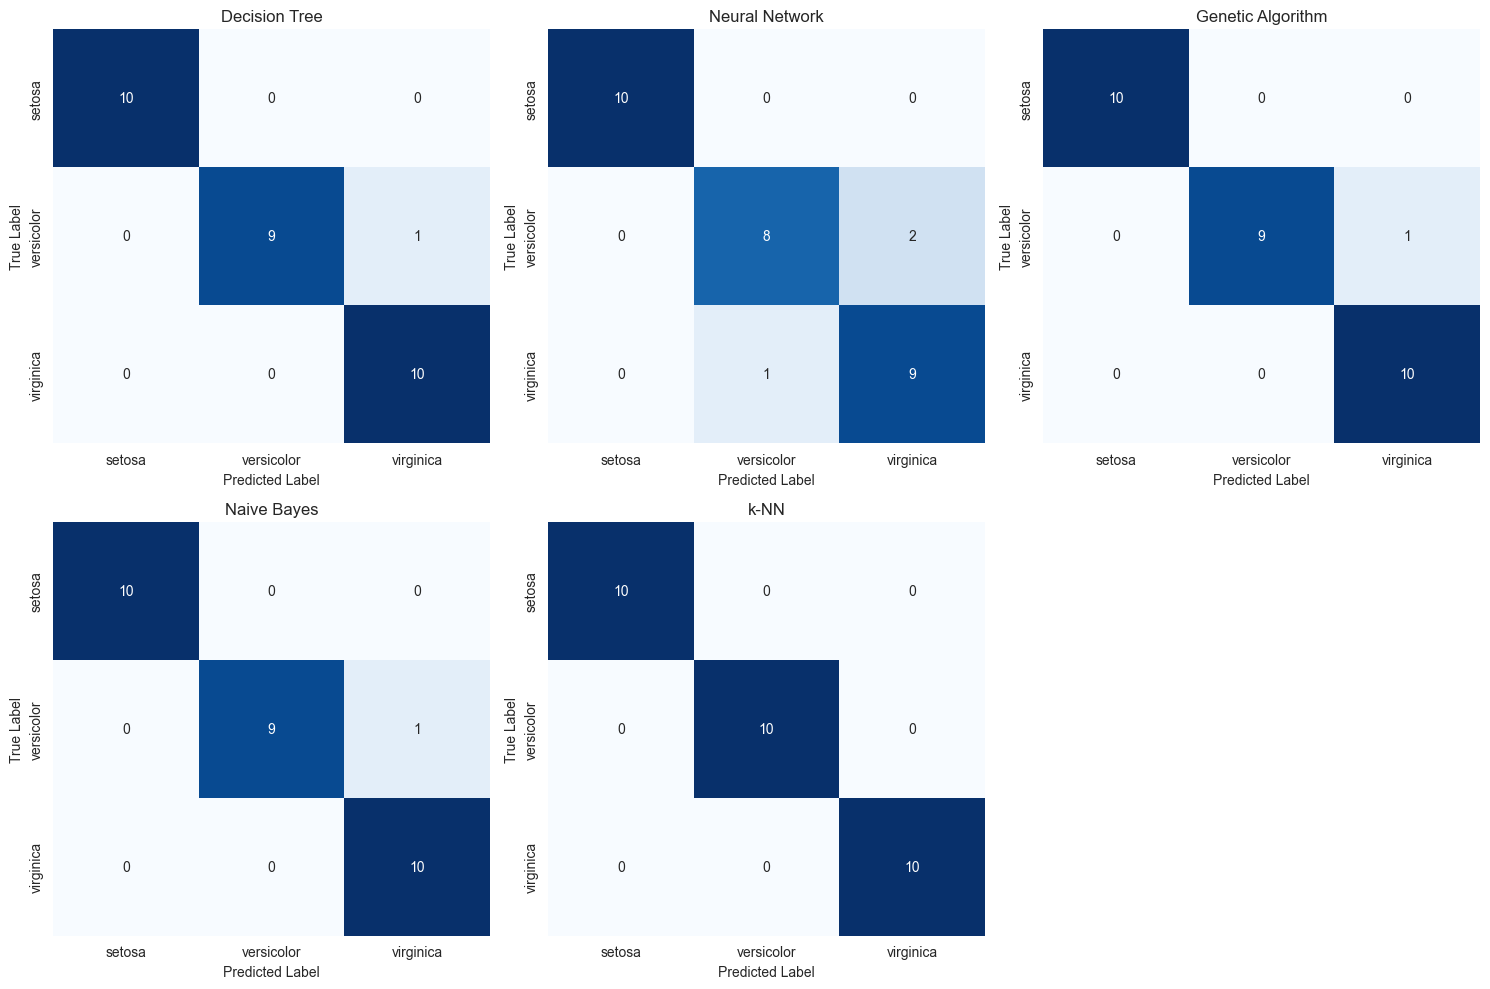

💡 Notice which species each tribe struggles with (if any)!


In [23]:
# Compare confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

predictions = [
    ('Decision Tree', y_pred_tree),
    ('Neural Network', y_pred_nn),
    ('Genetic Algorithm', y_pred_evo),
    ('Naive Bayes', y_pred_nb),
    ('k-NN', y_pred_knn)
]

for idx, (name, y_pred) in enumerate(predictions):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=target_names, yticklabels=target_names,
               ax=axes[idx], cbar=False)
    axes[idx].set_title(name)
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

# Hide the extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()

print("💡 Notice which species each tribe struggles with (if any)!")

### When to Use Each Tribe

| Tribe | Best For | Avoid When |
|-------|----------|------------|
| 🌳 **Symbolists** | Need interpretability, explaining decisions to stakeholders, moderate data | Very large datasets, need high accuracy on complex patterns |
| 🧠 **Connectionists** | Large datasets, complex patterns (images, audio, text), raw data | Need to explain decisions, small data, limited compute |
| 🧬 **Evolutionaries** | Can't compute gradients, discrete optimization, complex search spaces | Time-critical applications, need fast convergence |
| 📊 **Bayesians** | Need probability estimates, small data, handling uncertainty | Features are highly correlated, need precise probabilities |
| 📏 **Analogizers** | Need to explain by example, moderate data, multi-class problems | Very large datasets, high-dimensional data, need speed |

### Key Takeaways

1. **No single best approach** - each tribe excels in different situations
2. **They complement each other** - combining tribes can work even better
3. **Philosophy matters** - understanding *why* an algorithm works helps you use it well
4. **The Master Algorithm** - Domingos envisions combining all five approaches into one

### Toward the Master Algorithm

The "holy grail" of machine learning is a single algorithm that combines the strengths of all five tribes:
- **Symbolists**: Interpretability and logical structure
- **Connectionists**: Learning complex representations
- **Evolutionaries**: Optimization without gradients
- **Bayesians**: Handling uncertainty
- **Analogizers**: Recognizing similarity

Some modern approaches are already doing this:
- **Probabilistic programming** (Bayesian + Symbolist)
- **Neural-symbolic AI** (Connectionist + Symbolist)
- **AutoML** (Evolutionary + any tribe)
- **Ensemble methods** (combining multiple tribes)

The quest continues!

<a id="glossary"></a>
## Glossary

**Accuracy**: Percentage of correct predictions

**Activation Function**: Non-linear transformation in neural networks (ReLU, sigmoid, etc.)

**Backpropagation**: Algorithm for training neural networks by computing gradients

**Bayes' Theorem**: Formula for updating probabilities based on evidence

**Classification**: Predicting which category something belongs to

**Confusion Matrix**: Table showing correct and incorrect predictions by class

**Crossover**: Genetic algorithm operation that combines two parents

**Decision Boundary**: Line/surface separating different classes in feature space

**Epoch**: One complete pass through the training data

**Feature**: Measurable property used for prediction (e.g., petal length)

**Fitness**: How well a genetic algorithm individual solves the problem

**Gradient Descent**: Optimization by following the slope downhill

**k-Nearest Neighbors (k-NN)**: Classify based on k most similar training examples

**Mutation**: Random change in genetic algorithms

**Neural Network**: Model inspired by brain structure, with layers of connected neurons

**Overfitting**: Model learns training data too well, fails on new data

**Posterior Probability**: Updated belief after seeing evidence (Bayesian)

**Prior Probability**: Initial belief before seeing evidence (Bayesian)

**Test Set**: Data held out for final evaluation

**Training Set**: Data used to teach the model

**Validation Set**: Data used to tune hyperparameters during training

## Further Reading

### The Book
- **"The Master Algorithm"** by Pedro Domingos - the inspiration for this notebook

### Learn More
- [Scikit-learn Documentation](https://scikit-learn.org/) - ML library we used
- [TensorFlow Tutorials](https://www.tensorflow.org/tutorials) - Deep learning
- [DEAP Documentation](https://deap.readthedocs.io/) - Genetic algorithms

### Next Steps
1. **Experiment**: Try changing parameters and see what happens
2. **New datasets**: Apply these approaches to different problems
3. **Combine tribes**: Experiment with ensemble methods
4. **Deep dive**: Pick your favorite tribe and study it deeply

---

**Thank you for exploring the five tribes of machine learning!**

*"The grand aim of science is to cover the greatest number of experimental facts by logical deduction from the smallest number of hypotheses or axioms." - Albert Einstein*